In [73]:
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import binom
from scipy.stats import beta

warnings.filterwarnings( 'ignore' )

# Bayesian A/B testing

Suppose you want to run an A/B/n test on your website's landing page and randomly (evenly) assign each user to a variation:
- Control - the current version of the website with an orange button
- Variation A - updates the button color to blue
- Variation B - updates the button color to red

You know that the control has a conversion rate of about .05 (i.e. 5%) with a variance of about .025, thus conversions rage from .025 to .075. You think that one of the variations may increase the mean conversion rate by 1-2%.

You want to calculate your findings on a daily basis until you feel like you have enough evidence to make a decision on which variation performs the best.

## Methodology

Let's look at all the key assumptions you need to consider and the calculations you'll need to make each time you want to update your results. 

### Parameters of Interest

The main parameters you'll want to consider are the conversion rates for each variation. Let's call these:
- $\theta_{c}$ - The true probability that a user will convert on the control
- $\theta_{a}$ - The true probability that a user will convert on variation a
- $\theta_{b}$ - The true probability that a user will convert on variation b

### Likelihood

Because an A/B test can be considered a binomial experiment, you can use a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) for the likelihood.

The binomial distribution $Binom(n,p)$ is discrete, where n is the total trials and p is the probability.

When we know the number of successes and trials we can estimate the probability using the Maximum Likelihood Estimator (MLE):

$$\text{MLE} = \frac{\text{successes}}{\text{trials}}$$

Here is a binomial distribution with a $.2$ probability. 

If you plot enough data points we can see that is starts looking a lot like a normal distribution. The two plots show the same distribution, but the first plot generates the distribution using random samples, the second one calculates values within a range.

References:
* [Binomial Distribution - Wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution)

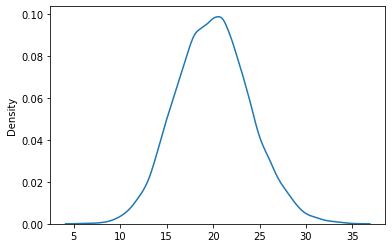

In [575]:
# https://www.w3schools.com/python/numpy_random_binomial.asp

successes = 20
n = 100 # trials
p = successes / n
sns.distplot( random.binomial( n=n, p=p, size=10000 ), hist=False, label='binomial' )
plt.show()

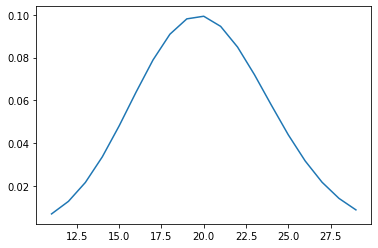

In [642]:
from scipy.stats import binom

successes = 20
n = 100 # trials
p = successes / n
# x = np.linspace( binom.ppf(0.01, n, p), binom.ppf(0.99, n, p), 20 )
x = np.arange( start=binom.ppf( 0.01, n, p ),
               stop=binom.ppf( 0.99, n, p ),
               step=1 
             )
y = binom.pmf( x, n, p )
plt.plot( x, y )
plt.show()

### Beta Distributions & Priors

The Beta distribution is continuous and has an $\alpha$ and $\beta$ parameter. It is quite a versatile distribution as the magnitude and ratio of $\alpha$ and $\beta$ can give the distribution quite a few different shapes. 

Here is a Beta distribution with $\alpha=2$ and $\beta=2$. 

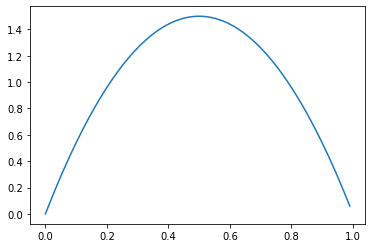

In [648]:
a = 2
b = 2
x = np.arange( 0, 1, 0.01 )
y = beta.pdf( x, a, b )
plt.plot( x, y )
plt.show()

Here is a Beta distribution with $\alpha=1$ and $\beta=1$. When used as a prior, this is often called an *uninformative prior* because all parameter values have the same probability.

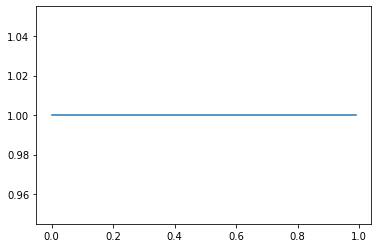

In [651]:
a = 1
b = 1
x = np.arange( 0, 1, 0.01 )
y = beta.pdf( x, a, b )
plt.plot( x, y )
plt.show()

The mean (Expected Value) of a Beta distribution can easily be calculated as follows:

$$\frac{\alpha}{\alpha+\beta}$$

We'll talk about the Expected Value more later.

### Selecting a Prior

The [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for a binomial likelihood is a Beta prior. That means that if you use a Beta prior, you will also get a Beta posterior. We'll talk about this more when we discuss the posterior distribution.

Regardless of what the initial prior probability distribution (informative or uninformative) you decide to use, if you have enough samples (trials) in your experiment, you will converge on the same posterior distribution.

However, the benefit of having an informative prior is that you can get to a meaningful result with fewer samples. That means that you can decide on a winner and end your experiment faster. In turn, that means that you can run more experiments, gain more revenue, or provide a better experience to your users faster.

Assuming you want to use an informative prior, you can select $\alpha$ and $\beta$ parameters (called *hyperparameters*) to give you a prior distribution for theta by leveraging what you know about your conversion rates. 

When selecting the prior, you can use your knowledge about the existing website conversion rate. Since you know your current website conversion is .05 with a variance of 0.025, a good prior might be centered on .05 and have the majority of its density between 0.025 to 0.075:
- $\theta > 0.025$ - Much of the probability mass should be above this
- $\theta > 0.05$ - About 1/2 of our mass should be above this
- $\theta > 0.075$ - Little of the probability mass should be above this

The Beta distribution has a nice feature that allows you to create a distribution that centers around a number by merely using a ratio of $\frac{ \alpha }{ \alpha + \beta }$ that equals that number.

For example, if you go with $\alpha=50$ and $\beta=950$ will give you $\frac{ 50 }{ 50 + 950 } = .05$ so it centers on .05.

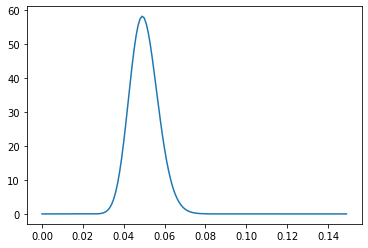

In [559]:
a = 50
b = 950
x = np.arange( 0.0, .15, 0.001 )
y = beta.pdf( x, a, b )
plt.plot( x, y )
plt.show()

That looks good, but let's check it by calculating the probability of this distriution when $\theta$ is above 0.025, 0.05, and 0.075.

In [636]:
cdf1 = 1 - beta.cdf( x=0.025, a=50, b=950)
cdf2 = 1 - beta.cdf( x=0.05,  a=50, b=950)
cdf3 = 1 - beta.cdf( x=0.075, a=50, b=950)
print( "Using hyperparameters a=50 and b=950:" )
print( "theta > 0.025 = %2.3f" % cdf1 )
print( "theta > 0.05 = %2.3f" % cdf2 )
print( "theta > 0.075 = %2.3f" % cdf3 )

Using hyperparameters a=50 and b=950:
theta > 0.025 = 1.000
theta > 0.05 = 0.483
theta > 0.075 = 0.001


Not too bad! Most of the probability is within the range you want, and the center at 4.8% is a bit off but not too much.

What if you go with smaller hyperparameters like $\alpha=5$ and $\beta=95$? This will achieve the same ratio because $\frac{5}{5+95}=.05$ as well.

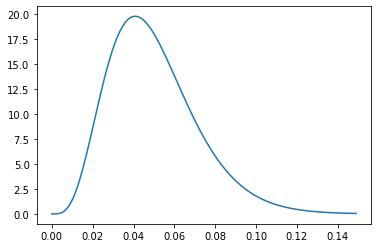

In [561]:
a = 5
b = 95
x = np.arange( 0.0, .15, 0.001 )
y = beta.pdf( x, a, b )
plt.plot( x, y )
plt.show()

It looks like those hyperparameters approximately maintained the 5% ratio, but notice there is a bit of a right skew now. That's because the Beta distribution has a skew when you use smaller hyperparameter values.

Let's check out the probabilities:

In [639]:
cdf1 = 1 - beta.cdf( x=0.025, a=5, b=95 )
cdf2 = 1 - beta.cdf( x=0.05,  a=5, b=95 )
cdf3 = 1 - beta.cdf( x=0.075, a=5, b=95 )
print( "Using hyperparameters a=5 and b=95:" )
print( "theta > 0.025 = %2.3f" % cdf1 )
print( "theta > 0.05 = %2.3f" % cdf2 )
print( "theta > 0.075 = %2.3f" % cdf3 )

Using hyperparameters a=5 and b=95:
theta > 0.025 = 0.897
theta > 0.05 = 0.445
theta > 0.075 = 0.128


That actually has a slightly more centered distribution, but there is now a bit more density above and below the variance range. That might be ok because it is a little broader so your prior will inform your outcome a little less when your sample size is small. Also, since you're expecting that one of your variations will increase your conversion rate, your posterior might shift things higher anyways.

You can use even smaller hyperparameters of $\alpha=1$ and $\beta=19$ since $\frac{1}{1 + 19} = 0.05$. But, with parameters that small, the beta Beta distribution changes altogether.

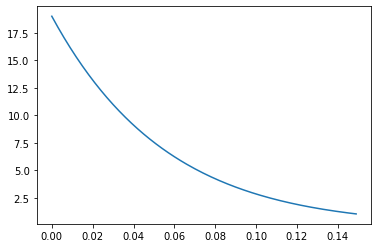

In [640]:
a = 1
b = 19
x = np.arange( 0.0, .15, 0.001 )
y = beta.pdf( x, a, b )
plt.plot( x, y )
plt.show()

This is actually one of the strengths of the Beta distribution in that using just the two parameters you can make it take many different forms. The tradeoff, however is that it gets a little tricker to have a normal (i.e. gaussian) looking distribution when you're working with smaller parameter values.

Let's look at the theta probabilites for these hyperparameters.

In [638]:
cdf1 = 1 - beta.cdf( x=0.025, a=1, b=19 )
cdf2 = 1 - beta.cdf( x=0.05,  a=1, b=19 )
cdf3 = 1 - beta.cdf( x=0.075, a=1, b=19 )
print( "Using hyperparameters a=1 and b=19:" )
print( "theta > 0.025 = %2.3f" % cdf1 )
print( "theta > 0.05 = %2.3f" % cdf2 )
print( "theta > 0.075 = %2.3f" % cdf3 )

Using hyperparameters a=1 and b=19:
theta > 0.025 = 0.618
theta > 0.05 = 0.377
theta > 0.075 = 0.227


This is quite different than the previous distributions because it is now giving you about 40% of your probability density under 0.025, which is mostly out of the range you'd expect given the variance of your current conversion rate. 

But, the fact that it is keeping the majority of your density under 0.075 is still mostly informing the upper end of your expected range.

The nice thing about the Bayesian model is that sequential and cumulative analysis will produce the same results. So, it's quite easy to just try out a different prior distribution at any point in your A/B test to see if it has any impact.

For the purposes of this example, we'll continue with an uninformative Beta prior with $\alpha=1$ and $\beta=1$.

### Posterior Distribution

Because you're using a Beta distribution as a prior, you'll also get a Beta distribution for your posterior.

You can think of the $\alpha$ and $\beta$ values as representing successes and failures, respectively. So:

$$Beta( \alpha=\text{ successes }, \beta=\text{ failures } )$$

As you get more evidence, you merely need to update your $\alpha$ and $\beta$ values. You'll add your new evidence (new success and failure counts) to your prior evidence (previously measured success and failure counts).

So, calculating the posterior distribution is quite simple. Skipping all the theory, all you need to do is calculate your new $\alpha$ and $\beta$ parameters using the following rules and plug them back in to the Beta distribution:

$$Beta( a = a_{\text{posterior}}, b = b_{\text{posterior}} )$$

Where
* $a_{\text{posterior}}$ = $a_{\text{prior}}$ + successes
* $b_{\text{posterior}}$ = $b_{\text{prior}}$ + trials - successes

For example let's say you're using a prior of:

$Beta( \alpha=5, \beta=95 )$

Then after a day, let's say one of your variations gets 11 successes (i.e. conversions) out of 150 trials.

The posterior distribution would be:

$Beta( \alpha=5+11, \beta=95+150-11 )$

So the posterior probability of your conversion rate for this variation would look like this:

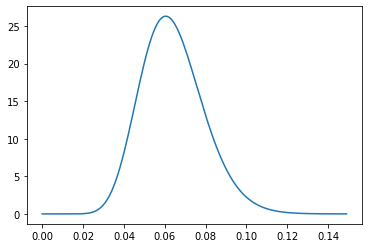

In [641]:
a = 5+11
b = 95+150-11
x = np.arange( 0.0, .15, 0.001 )
y = beta.pdf( x, a, b )
plt.plot(x,y)
plt.show()

It looks like the posterior is approximately centered at 0.06. 

It is common to look at the Expected Value of the Posterior Beta Distribution and compare it to the Maximum Likelihood Estimator (MLE) for your likelihood function (your evidence). With a sufficiently large sample size, these tend to converge, but typically the Posterior Mean will lie between your Prior Mean and the MLE. 

Let's look at the Mean (Expected Value) of the Posterior Beta distribution and the MLE of the likelihood function. 

Posterior Mean:
$$\frac{\alpha}{\alpha+\beta}$$

Maximum Likelihood Estimate (MLE):
$$\frac{\text{successes}}{\text{trials}}$$

In [622]:
prior_a = 5
prior_b = 95
successes = 11
trials = 150
posterior_a = prior_a + successes
posterior_b = prior_b + trials - successes
posterior_mean = posterior_a / ( posterior_a + posterior_b )
mle = successes / trials

print( "Posterior Mean: %2.3f" % posterior_mean )
print( "Maximum Likelihood Estimate: %2.3f" % mle )

Posterior Mean: 0.064
Maximum Likelihood Estimate: 0.073


You can also calculate the equal tail 95% credible interval to see where most of the probability lies:

In [623]:
lower = beta.ppf( q=0.025, a=posterior_a, b=posterior_b, loc=0, scale=1)
upper = beta.ppf( q=0.975, a=posterior_a, b=posterior_b, loc=0, scale=1)

print( "Equal tail 95% credible interval" )
print( "Lower bound: %2.3f" % lower )
print( "Upper bound: %2.3f" % upper )

Equal tail 95% credible interval
Lower bound: 0.037
Upper bound: 0.097


So, with one day of data, it is 95% likely that the conversion rate for Variation A is between 3.6% and 9.5%. Of course, the more data you get the tighter the range will get.

Let see what would happen if you got another day's worth of data. This time you got 8 successes (i.e. conversions) out of 142 trials.

You can calculate the new posterior probability for day two in one of two ways:
* sum up the total cumulative success across all days and rerun the calculation against the original prior
* use the $\alpha$ and $\beta$ values from your previous day as your new prior and plug in your incremental trails and successes for day two

Both methods will give you the same result, but let's use the second method. Your previous day's posterior alpha and beta were:
* $a = 5 + 11 = 16$
* $b = 95 + 150 - 11 = 234$

Now you can use those as the prior when calculating the posterior for day two:

Beta( a=16+8, b=234+142-8 )

So the updated posterior results are:

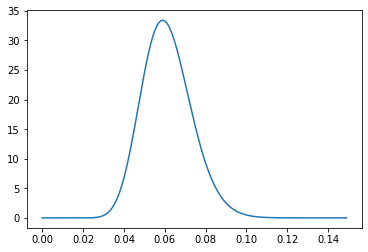

In [625]:
prior_a = 16
prior_b = 234
successes = 8
trials = 142
posterior_a = prior_a + successes
posterior_b = prior_b + trials - successes
posterior_mean = posterior_a / ( posterior_a + posterior_b )
mle = successes / trials

x = np.arange( 0.0, .15, 0.001 )
y = beta.pdf( x,posterior_a,posterior_b )
plt.plot( x, y )
plt.show()

In [626]:
print( "Posterior Mean: %2.3f" % posterior_mean )
print( "Maximum Likelihood Estimate: %2.3f" % mle )

lower = beta.ppf( q=0.025, a=posterior_a, b=posterior_b, loc=0, scale=1 )
upper = beta.ppf( q=0.975, a=posterior_a, b=posterior_b, loc=0, scale=1 )

print()
print( "Equal tail 95% credible interval" )
print( "Lower bound: %2.3f" % lower )
print( "Upper bound: %2.3f" % upper )

Posterior Mean: 0.061
Maximum Likelihood Estimate: 0.056

Equal tail 95% credible interval
Lower bound: 0.040
Upper bound: 0.087


As you can see the shape of the updated posterior distribution is quite similar, but the width has tightened and the height has increased slightly. The more evidence you collect, the more your probability range will narrow.

### Comparing Variations

You now know how to select a prior distribution and how to calculate the posterior distribution, posterior mean, and Maximum Likelihood Estimate.

But how do you know which variation won?

You can do this mathematically and get a precise answer, but the equations and even the code can get a [little complex](https://www.evanmiller.org/bayesian-ab-testing.html).

The easier way is to use a [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) or sampling method where you take a large number of random samples from the posterior distribution of each variation and see which one is selected the most often.

Let's take 200,000 random samples from each of three distributions and see which one has the highest probability of winning:

In [440]:
# https://stackoverflow.com/questions/55062928/how-to-compare-3-numpy-arrays-elementwise-and-get-the-results-as-the-array-with

def print_winner( control, variation_a, variation_b ):
    max = np.argmax( ( control, variation_a, variation_b ), 0)
    unique, counts = np.unique(max, return_counts=True, return_index=False)
    frequencies = np.asarray((unique, counts)).T
    
    for f in frequencies:
        names = [ 'Control', 'Variation A', 'Variation B' ]
        print( names[ f[ 0 ] ], '-', "%2.3f" % ( f[ 1 ] / n )  )

control_a = 690
control_b = 10000
variation_a_a = 700
variation_a_b = 10000
variation_b_a = 720
variation_b_b = 10000

n=200000

control=beta.rvs(size=n,a=control_a,b=control_b,loc=0,scale=1)
variation_a=beta.rvs(size=n,a=variation_a_a,b=variation_a_b,loc=0,scale=1)
variation_b=beta.rvs(size=n,a=variation_b_a,b=variation_b_b,loc=0,scale=1)

print_winner( control, variation_a, variation_b )

Control - 0.149
Variation A - 0.250
Variation B - 0.600


### Value at Risk

You may have a conversion rate threshold under which you aren't willing to go. Similar to how we compared the variations, you can take samples from your distribution and compare them to your threshold to find a probability of going under that threshold.

Let's say one of your variations has have a posterior $\alpha=500$ and $\beta=9500$ (a ratio of 5%) and you want to find out what the Value at Risk of being below 4.7%. 


In [634]:
# https://youtu.be/UxEFAkDlkiA?t=2033
n=200000
threshold=.047

samples=beta.rvs( size=n, a=500, b=9500, loc=0, scale=1 )
value_at_risk = np.mean( samples < threshold )
print("Probability that conversion rate is less than 4.4%:", value_at_risk )

Probability that conversion rate is less than 4.4%: 0.08289


## Running Your Experiment

OK, so you start running your test. In a real scenario you would collect data realtime, hourly, data, or whenever it is made available to you. Then you would report periodically and decide on when to end your experiment based on the evidence.

For the purposes of this example, we're going to generate a bunch of daily data up front and then see what a daily analysis would look like.

### Setup

We're going to generate 30 days worth of data.

We're randomly generating normally distributed trial counts for each variation, centered around 150 / day. 

We're randomly generating normally distributed success counts for each variation, centered around:
- Control - 5%
- Variation A - 6%
- Variation B - 4%

Of course, you wouldn't know your conversion rate information up front in a real A/B test, except perhaps for your control. But, for the purposes of this example, we can use this up-front information to learn how many days it takes us to become confident in our findings.

In [635]:
import pandas as pd

days = 30
trials_per_day = 150
variance = .01

control_success_rate = .05
variation_a_success_rate = .06
variation_b_success_rate = .04


def generate_success_array( success_rate ):
    return np.random.normal( success_rate * trials_per_day, variance * trials_per_day, days).round()

def generate_trials_array():
    return np.random.normal( 150, 10, days).round()

d = { 
    'Control Successes':     generate_success_array( control_success_rate ), 
    'Control Trials':        generate_trials_array(),
    'Variation A Successes': generate_success_array( variation_a_success_rate ), 
    'Variation A Trials':    generate_trials_array(),
    'Variation B Successes': generate_success_array( variation_b_success_rate ), 
    'Variation B Trials':    generate_trials_array(),
}
experiment_data = pd.DataFrame( d )
experiment_data

,Control Successes,Control Trials,Variation A Successes,Variation A Trials,Variation B Successes,Variation B Trials
0,7.0,157.0,9.0,148.0,6.0,168.0
1,9.0,139.0,8.0,136.0,5.0,154.0
2,10.0,143.0,11.0,158.0,5.0,162.0
3,7.0,139.0,12.0,161.0,3.0,151.0
4,7.0,150.0,12.0,155.0,6.0,140.0
5,9.0,140.0,11.0,166.0,6.0,144.0
6,8.0,147.0,10.0,149.0,6.0,146.0
7,6.0,156.0,10.0,151.0,6.0,142.0
8,8.0,130.0,11.0,148.0,4.0,162.0
9,9.0,163.0,9.0,147.0,5.0,148.0


Next, let's set up some Python classes to track our Experiment and Variation state as it executes. 

We're going to use $\alpha=1$ and $\beta=1$ uninformative prior distributions for three the variations.

In [595]:
def plot_beta( a, b ):
    x = np.arange (0.0, .15, 0.001)
    y = beta.pdf(x, a=post_a, b=post_b)
    plt.plot(x,y)
    plt.show()

SAMPLE_COUNT = 200000

VARIATIONS = [ 'Control', 'Variation A', 'Variation B' ]
    
class Variation:
    def __init__( self, name, prior_a, prior_b, value_at_risk ):
        self._name = name
        self._prior_a = prior_a
        self._prior_b = prior_b
        self._value_at_risk_threshold = value_at_risk
        self._posterior_a = 0
        self._posterior_b = 0
        self._trials = 0
        self._successes = 0
        self._value_at_risk = 0
    
    def add_trials( self, successes, trials ):
        self._trials = self._trials + trials
        self._successes = self._successes + successes
        
        self._posterior_a = self.prior_a() + self._successes
        self._posterior_b = self.prior_b() + self._trials - self._successes

        # calculate value at risk
        samples=beta.rvs(
            size=SAMPLE_COUNT,
            a=self._posterior_a,
            b=self._posterior_b,
            loc=0,
            scale=1
        )
        self._value_at_risk = np.mean( samples < self._value_at_risk_threshold )
        
    def value_at_risk( self ):
        return self._value_at_risk
    
    def name( self ):
        return self._name
    
    def prior_a( self ):
        return self._prior_a

    def prior_b( self ):
        return self._prior_b
    
    def posterior_a( self ):
        return self._posterior_a

    def posterior_b( self ):
        return self._posterior_b

    def maximum_likelihood_estimate( self ):
        return self._successes / self._trials

    def posterior_mean( self ):
        return self._posterior_a / ( self._posterior_a + self._posterior_b )

    def credible_interval( self ):
        lower = beta.ppf( q=0.025, a=self.posterior_a(), b=self.posterior_b(), loc=0, scale=1 )
        upper = beta.ppf( q=0.975, a=self.posterior_a(), b=self.posterior_b(), loc=0, scale=1 )
        return ( lower, upper )

    def print_summary( self ):
        print( "----", self.name(), "----")
        print( "Posterior alpha:", self.posterior_a() )
        print( "Posterior beta:", self.posterior_b() )
        print( "Posterior Mean: %2.3f" % self.posterior_mean() )
        print( "Maximum Likelihood Estimate: %2.3f" % self.maximum_likelihood_estimate() )
        print( "Probability that conversion rate is less than %2.3f" % self._value_at_risk_threshold, "-", self._value_at_risk )

        ( lower, upper ) = self.credible_interval()

        print()
        print( "Equal tail 95% credible interval" )
        print( "Lower bound: %2.3f" % lower )
        print( "Upper bound: %2.3f" % upper )

        plot_beta( post_a, post_b )
    
    def sample_from_posterior( self ):
        return beta.rvs(
            size=SAMPLE_COUNT, 
            a=self.posterior_a(), 
            b=self.posterior_b(), 
            loc=0, 
            scale=1
        )

class Experiment:
    def __init__( self, experiment_data, initial_prior_a, initial_prior_b, value_at_risk ):
        self._data = experiment_data
        self._day = -1
        self._control = Variation( 'Control', initial_prior_a, initial_prior_b, value_at_risk )
        self._variation_a = Variation( "Variation A", initial_prior_a, initial_prior_b, value_at_risk )
        self._variation_b = Variation( "Variation B", initial_prior_a, initial_prior_b, value_at_risk )
        self._daily_results = pd.DataFrame(
            columns=[
                'Control', 
                'Variation A',
                'Variation B',
                'Value at Risk for Winner',
                'MLE for Winner',
                'Posterior Mean for Winner',
                'Lower Credible Interval for Winner',
                'Upper Credible Interval for Winner',
            ]
        )

    def get_winning_variation( self ):
        # can almost definitely simplify this using a map() or something
        control_count = 0
        variation_a_count = 0
        variation_b_count = 0
        for f in self._frequencies:
            if ( f[ 0 ] == 0 ):
                control_count = f[ 1 ]
            elif ( f[ 0 ] == 1 ):
                variation_a_count = f[ 1 ]
            elif ( f[ 0 ] == 2 ):
                variation_b_count = f[ 1 ]
        
        return np.argmax( [ control_count, variation_a_count, variation_b_count ] )

    def next_day( self ):
        self._day = self._day + 1
        self._control.add_trials( self.control_successes(), self.control_trials() )
        self._variation_a.add_trials( self.variation_a_successes(), self.variation_a_trials() )
        self._variation_b.add_trials( self.variation_b_successes(), self.variation_b_trials() )
        
        # calculate winner
        control_samples = self._control.sample_from_posterior()
        variation_a_samples = self._variation_a.sample_from_posterior()
        variation_b_samples = self._variation_b.sample_from_posterior()
        
        max = np.argmax( ( control_samples, variation_a_samples, variation_b_samples ), 0)
        (unique, counts) = np.unique(max, return_counts=True)
        self._frequencies = np.asarray((unique, counts)).T   
        
        # update daily results
        control_percent = 0
        variation_a_percent = 0
        variation_b_percent = 0
        for f in self._frequencies:
            if ( f[ 0 ] == 0 ):
                control_percent = f[ 1 ] / SAMPLE_COUNT
            elif ( f[ 0 ] == 1 ):
                variation_a_percent = f[ 1 ] / SAMPLE_COUNT
            elif ( f[ 0 ] == 2 ):
                variation_b_percent = f[ 1 ] / SAMPLE_COUNT
        
        winner_index = self.get_winning_variation()
#         value_at_risk, mle, mean, lower, upper = 0

        if ( winner_index == 0 ):
            value_at_risk = self._control.value_at_risk()
            mle = self._control.maximum_likelihood_estimate()
            mean = self._control.posterior_mean()
            lower, upper = self._control.credible_interval()
        elif ( winner_index == 1 ):
            value_at_risk = self._variation_a.value_at_risk()
            mle = self._variation_a.maximum_likelihood_estimate()
            mean = self._variation_a.posterior_mean()
            lower, upper = self._variation_a.credible_interval()
        elif ( winner_index == 2 ):
            value_at_risk = self._variation_b.value_at_risk()
            mle = self._variation_b.maximum_likelihood_estimate()
            mean = self._variation_b.posterior_mean()
            lower, upper = self._variation_b.credible_interval()
        
        self._daily_results.loc[ self._day ] = [ 
            control_percent, 
            variation_a_percent, 
            variation_b_percent, 
            value_at_risk,
            mle,
            mean,
            lower,
            upper,
        ]

    def get_daily_results( self ):
        return self._daily_results
    
    def fetch_cell( self, name ):
        return self._data[ self._day : self._day + 1 ].at[ self._day, name ]
        
    def control_successes( self ):
        return self.fetch_cell( 'Control Successes' )

    def control_trials( self ):
        return self.fetch_cell( 'Control Trials' )
    
    def variation_a_successes( self ):
        return self.fetch_cell( 'Variation A Successes' )

    def variation_a_trials( self ):
        return self.fetch_cell( 'Variation A Trials' )
    
    def variation_b_successes( self ):
        return self.fetch_cell( 'Variation B Successes' )

    def variation_b_trials( self ):
        return self.fetch_cell( 'Variation B Trials' )
    
    def print_summary( self ):
        print( "Results for day", self._day + 1 )
        print()
        self._control.print_summary()
        self._variation_a.print_summary()
        self._variation_b.print_summary()


In [618]:
# Rerun from here to reset the experiment
# initial_prior_a = 50
# initial_prior_b = 950
initial_prior_a = 1
initial_prior_b = 1
value_at_risk_threshold = 0.047

experiment = Experiment( experiment_data, initial_prior_a, initial_prior_b, value_at_risk_threshold )

### Day 1

After you collect the first day's data, you can run through the analysis outlined above to see what each variaiton looks like and which one is most likely to be the winner.

Results for day 1

---- Control ----
Posterior alpha: 8.0
Posterior beta: 132.0
Posterior Mean: 0.057
Maximum Likelihood Estimate: 0.051
Probability that conversion rate is less than 0.047 - 0.33085

Equal tail 95% credible interval
Lower bound: 0.025
Upper bound: 0.101


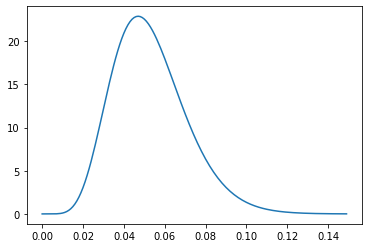

---- Variation A ----
Posterior alpha: 11.0
Posterior beta: 136.0
Posterior Mean: 0.075
Maximum Likelihood Estimate: 0.069
Probability that conversion rate is less than 0.047 - 0.08489

Equal tail 95% credible interval
Lower bound: 0.038
Upper bound: 0.122


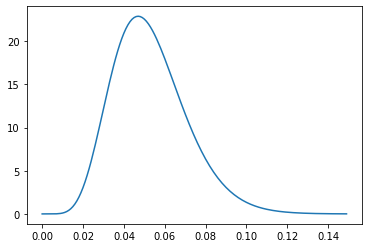

---- Variation B ----
Posterior alpha: 5.0
Posterior beta: 155.0
Posterior Mean: 0.031
Maximum Likelihood Estimate: 0.025
Probability that conversion rate is less than 0.047 - 0.87261

Equal tail 95% credible interval
Lower bound: 0.010
Upper bound: 0.063


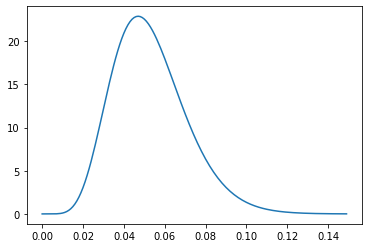

,Control,Variation A,Variation B,Value at Risk for Winner,MLE for Winner,Posterior Mean for Winner,Lower Credible Interval for Winner,Upper Credible Interval for Winner
0,0.259805,0.72098,0.019215,0.08489,0.068966,0.07483,0.03821,0.122353


In [619]:
experiment.next_day()
experiment.print_summary()
experiment.get_daily_results()

After just the first day, you should probably start seeing that Variation A is performing better than the others.

But you should almost always let A/B tests last at least a week to avoid fluctuations in behavior based on the day of week. Another good practice is to observe a 95% probability for the winning variation for over 3-4 consecutive days to make sure you're not just observing a temporary spike.

Let's see what the data looks as we move forward. 

### Remaining days


In [620]:
import builtins
range = builtins.range

for n in range( 0, len( experiment_data ) - 1 ):
    experiment.next_day()

pd.set_option( 'display.max_rows', None )
experiment.get_daily_results()

,Control,Variation A,Variation B,Value at Risk for Winner,MLE for Winner,Posterior Mean for Winner,Lower Credible Interval for Winner,Upper Credible Interval for Winner
0,0.259805,0.720980,0.019215,0.084890,0.068966,0.074830,0.038210,0.122353
1,0.173510,0.803740,0.022750,0.041710,0.067797,0.070707,0.044450,0.102426
2,0.160555,0.837825,0.001620,0.018870,0.068396,0.070423,0.048129,0.096529
3,0.094810,0.903245,0.001945,0.006765,0.069204,0.070690,0.051292,0.092888
4,0.062675,0.935800,0.001525,0.010200,0.065484,0.066667,0.049792,0.085772
5,0.038020,0.960810,0.001170,0.002320,0.068104,0.069083,0.053312,0.086700
6,0.019945,0.978850,0.001205,0.001485,0.067055,0.067895,0.053359,0.084018
7,0.014975,0.983495,0.001530,0.002250,0.064815,0.065546,0.052197,0.080278
8,0.019540,0.977845,0.002615,0.005100,0.062079,0.062733,0.050382,0.076322
9,0.019005,0.978980,0.002015,0.006255,0.060951,0.061538,0.049927,0.074260


### Final Variation Results

Results for day 30

---- Control ----
Posterior alpha: 221.0
Posterior beta: 4324.0
Posterior Mean: 0.049
Maximum Likelihood Estimate: 0.048
Probability that conversion rate is less than 0.047 - 0.311665

Equal tail 95% credible interval
Lower bound: 0.043
Upper bound: 0.055


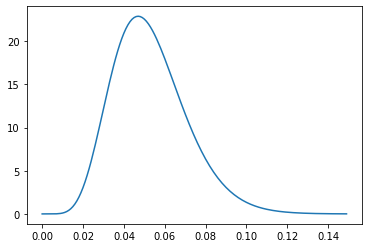

---- Variation A ----
Posterior alpha: 266.0
Posterior beta: 4241.0
Posterior Mean: 0.059
Maximum Likelihood Estimate: 0.059
Probability that conversion rate is less than 0.047 - 0.00015

Equal tail 95% credible interval
Lower bound: 0.052
Upper bound: 0.066


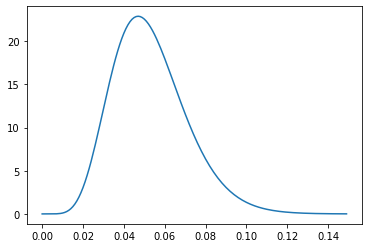

---- Variation B ----
Posterior alpha: 177.0
Posterior beta: 4329.0
Posterior Mean: 0.039
Maximum Likelihood Estimate: 0.039
Probability that conversion rate is less than 0.047 - 0.99451

Equal tail 95% credible interval
Lower bound: 0.034
Upper bound: 0.045


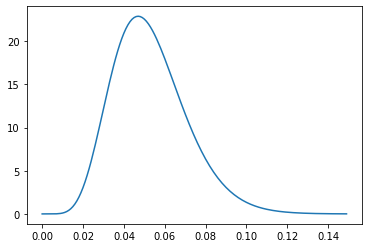

In [621]:
experiment.print_summary()

### Declaring a Winner

Well, after 30 days it seems pretty obvious that your Variation A won:
* Variation A should have little to no overlap with Variation B
* Variation A has just a little overlap with Control
* The evidence alone (i.e. the MLE for Variation A) shows a probability of $\theta=0.59$.
* Incorporating the prior also shows you a mean / expected value of $\theta=0.59$
* There is effectively no probability that shows you're at risk of going below your Value at Risk of 4.7% conversion
* The lower band of the 95% credible interval for Variation A is above long-run conversion rate of 5% for the control that you started the experiment with


# References
* [Bayesian A/B Test Calculator - Lyst](https://making.lyst.com/bayesian-calculator/)
* [Bayesian A/B Testing - Lyst](https://making.lyst.com/2014/05/10/bayesian-ab-testing/)
* [Split Test Calculator: Bayesian A/B Experiments Made Easy](https://yanirseroussi.com/2016/06/19/making-bayesian-ab-testing-more-accessible/)
* [Bayesian Statistics: From Concept to Data Analysis - Coursera](https://www.coursera.org/learn/bayesian-statistics/)
* [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)